In [1]:
import torch
torch.cuda.set_device(2)
if torch.cuda.is_available():
    current_gpu = torch.cuda.current_device()
    print(f"Current default GPU index: {current_gpu}")
    print(f"Current default GPU name: {torch.cuda.get_device_name(current_gpu)}")
else:
    print("No GPUs available.")

Current default GPU index: 2
Current default GPU name: NVIDIA A40


# imports

In [2]:
# all imports

# buffer
from collections import defaultdict
import random
from abc import ABC, abstractmethod
from typing import (
    Any,
    Dict,
    Generic,
    Optional,
    List,
    TYPE_CHECKING,
    Set,
    TypeVar,
)

from avalanche.benchmarks.utils import (
    classification_subset,
    AvalancheDataset,
)
from avalanche.models import FeatureExtractorBackbone
# from ..benchmarks.utils.utils import concat_datasets
from avalanche.benchmarks.utils import concat_datasets
from avalanche.training.storage_policy import ReservoirSamplingBuffer, BalancedExemplarsBuffer, ClassBalancedBuffer

from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy, ExemplarsBuffer, ExperienceBalancedBuffer
from avalanche.benchmarks.utils.data_loader import ReplayDataLoader
from avalanche.training.plugins import SupervisedPlugin
from typing import Optional, TYPE_CHECKING

from avalanche.benchmarks.utils import concat_classification_datasets
from avalanche.training.plugins.strategy_plugin import SupervisedPlugin

if TYPE_CHECKING:
    from avalanche.training.templates import SupervisedTemplate, BaseSGDTemplate

# dataset
from avalanche.benchmarks import SplitMNIST, SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR10
from avalanche.benchmarks.utils.data_loader import GroupBalancedDataLoader, ReplayDataLoader
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark
from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark, \
                                            tensors_benchmark, paths_benchmark

from avalanche.logging import InteractiveLogger, TensorboardLogger, \
    WandBLogger, TextLogger, TensorboardLogger

from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, loss_metrics

from avalanche.training.plugins.checkpoint import CheckpointPlugin, \
    FileSystemCheckpointStorage
from avalanche.training.determinism.rng_manager import RNGManager
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1, ICaRL
from avalanche.models import SimpleMLP
from avalanche.training.plugins import ReplayPlugin
from types import SimpleNamespace
from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import inf

In [4]:
# all imports

import torch
import os
from torch import cat, Tensor
from torch.nn import Module
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset, ConcatDataset, TensorDataset
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import datasets, transforms
import torch.optim.lr_scheduler # ?
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, CenterCrop, RandomHorizontalFlip, Resize
from torchvision.transforms.functional import center_crop
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.utils import save_image
from torchvision.transforms.functional import pil_to_tensor


In [5]:
# import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import os

stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

transform = transform_train = Compose([
    # Resize(224),
    # Resize(384),
    # RandomHorizontalFlip(),
    ToTensor(),
    # Normalize(*stats,inplace=True)
])

# Load the CIFAR-100 training set
trainset = torchvision.datasets.CIFAR100(root='data', train=True,
                                         download=True, transform=transform)

name_list = trainset.classes

Files already downloaded and verified


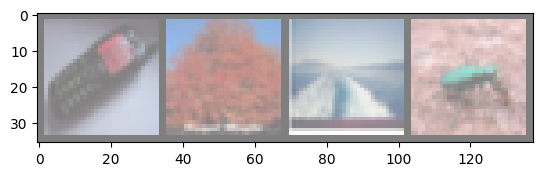

telephone maple_tree   sea beetle


In [6]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize if Normalize was used in transform
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(4)))


In [7]:

def tensor_to_pil(image_tensor):
    return transforms.ToPILImage()(image_tensor).convert("RGB")

In [8]:
import os
import torch
import torchvision
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, ToTensor
from torchvision.utils import save_image


def save_cifar100_random_replay(dataset, num_images_per_class, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    torch.manual_seed(41)

    saved_counts = {label: 0 for label in range(100)}  # Initialize saved image count for each class
    
    transform_to_tensor = transforms.ToTensor()
    
    indices = torch.randperm(len(dataset)).tolist()
    for idx in indices:
        image, label = dataset[idx]
        image_tensor = transform_to_tensor(image)

        # Skip saving if this class already has the desired number of images saved
        if saved_counts[label] >= num_images_per_class:
            continue

        class_name = dataset.classes[label]
        image_path = os.path.join(save_dir, f'{class_name}_{saved_counts[label]}.png')
        save_image(image_tensor, image_path)
        saved_counts[label] += 1

        # Check if we have finished saving max_images for all classes
        class_file_path = os.path.join(save_dir, f"class{label}.txt")
        with open(class_file_path, "a") as file:
            file.write(f"{image_path} {label}\n")

        # Check if we have finished saving the specified number of images for all classes
        if all(count >= num_images_per_class for count in saved_counts.values()):
            break

    print(f"Saved {num_images_per_class} images per class from the CIFAR-100 training dataset.")

In [9]:
# save_cifar100_random_replay(trainset, 50, 'saved_data/cifar0411_1')

In [10]:
integer_to_name = {i: name for i, name in enumerate(name_list)}


In [11]:
for id in integer_to_name:
    print(id, integer_to_name[id])
    break

0 apple


# Data transform

In [12]:
# !pip install pytorch_pretrained_vit


import torch
import matplotlib.pyplot as plt
import numpy as np
# ?

from avalanche.benchmarks.classic import SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR10

from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark

from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark, \
                                            tensors_benchmark, paths_benchmark



In [13]:
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, Resize
import os
# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
transform_train = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(*stats,inplace=True)
])

transform_test = Compose([
    Resize((224,224)),
    ToTensor(),
    Normalize(*stats,inplace=True)
])


In [14]:
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger
from avalanche.logging import InteractiveLogger, TensorboardLogger, \
    WandBLogger, TextLogger
# log to Tensorboard
tb_logger = TensorboardLogger()

# log to text file
text_logger = TextLogger(open('logs/test.txt', 'w'))

# print to stdout
interactive_logger = InteractiveLogger()

In [992]:
# evaluation
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, loss_metrics, class_accuracy_metrics

# The evaluation plugin manages the metrics computation.
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
#     loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    class_accuracy_metrics(minibatch=False, epoch=False, epoch_running=False, experience=False, stream=True),
    # forgetting_metrics(experience=True, stream=True),
    loggers=[interactive_logger, text_logger, tb_logger]
)

In [993]:
from avalanche.training.plugins.checkpoint import CheckpointPlugin, \
    FileSystemCheckpointStorage
from avalanche.training.determinism.rng_manager import RNGManager


In [994]:
RNGManager.set_random_seeds(1234)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

checkpoint_plugin = CheckpointPlugin(
    FileSystemCheckpointStorage(
        directory='./checkpoints/task_cifar',
    ),
    map_location=device
)

# Load checkpoint (if exists in the given storage)
# If it does not exist, strategy will be None and initial_exp will be 0
strategy, initial_exp = checkpoint_plugin.load_checkpoint_if_exists()

cuda


In [995]:
import os
import random

def combine_files_with_numbers(folder, file_initial, numbers, output_folder):
    """use to get the data with label in the training experience"""
    combined_content = ""  # Initialize an empty string to store combined content
    # Compile a set of filenames to look for, based on the list of numbers
    filenames_to_look_for = {file_initial + f"{number}.txt" for number in numbers}

    # Iterate over each file in the specified folder
    for file in os.listdir(folder):
        # Check if the file name matches exactly any in our set of filenames to look for
        if file in filenames_to_look_for:
            # Open and read the file, then add its content to the combined_content string
            with open(os.path.join(folder, file), 'r') as f:
                combined_content += f.read()  # Add a newline character after each file's content for better separation

    joined_string = '_'.join(str(integer) for integer in numbers)

    os.makedirs(output_folder, exist_ok=True)

    output_file_path = output_folder +file_initial+ 'combined' + '_' + joined_string + '.txt'
    print(output_file_path)
    with open(output_file_path, 'w') as f:
        f.write(combined_content)

def shuffle_text_file_lines(file_path):
    """
    Shuffles the lines in a text file.

    Parameters:
    - file_path: Path to the text file to shuffle.
    """
    # Read the lines from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Shuffle the lines
    random.shuffle(lines)

    # Write the shuffled lines back to the file
    with open(file_path, 'w') as file:
        file.writelines(lines)

# experiment 20 tasks

In [996]:
# training
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1

# strategies
from avalanche.models import SimpleMLP
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

In [997]:
import torch
import torch.nn as nn
# resnet50 = torch.hub.load('ckpt/dino_resnet50_pretrain.pth', 'dino_resnet50')
resnet_model = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
resnet_model.fc = nn.Identity()

for param in resnet_model.parameters():
    param.requires_grad = False
    

# # Step 2: Create a new network class with an additional linear layer
# class CustomNetwork(nn.Module):
#     def __init__(self, pretrained_model, num_classes):
#         super(CustomNetwork, self).__init__()
#         self.pretrained_model = pretrained_model
#         self.fc = nn.Linear(2048, num_classes)  # New linear layer with trainable weights

#     def forward(self, x):
#         # Extract features using the pre-trained model
#         features = self.pretrained_model(x)
#         # Flatten the output for the linear layer if not already flattened
#         features = torch.flatten(features, 1)
#         # Pass features through the new linear layer
#         output = self.fc(features)
#         return output

# # Step 3: Initialize the new network with the desired number of output classes
# num_classes = 100  # Example: 10 classes for a new classification task
# resnet_model = CustomNetwork(resnet_model, num_classes)

# # The only parameters that are trainable are those of the new linear layer


Using cache found in /homes/55/enbo/.cache/torch/hub/facebookresearch_dino_main


In [998]:
import torch.nn as nn
import torch
from avalanche.training.templates import SupervisedTemplate
from avalanche.benchmarks.utils import AvalancheDataset
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

import torch
from avalanche.training.plugins import SupervisedPlugin
from avalanche.benchmarks.utils.data_loader import ReplayDataLoader
from typing import Optional

class DINOFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # Load the pre-trained DINO model
        self.feature_extractor = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
        # Remove the head or adapt it to return features instead of logits
        self.feature_extractor.fc = nn.Identity()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Extract features using the DINO backbone
        return self.feature_extractor(x)

In [999]:
# training
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1

# strategies
from avalanche.models import SimpleMLP
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.training.plugins import ReplayPlugin

from types import SimpleNamespace

In [1000]:
benchmark = SplitCIFAR100(n_experiences=20,
                          train_transform=transform_train,
                          eval_transform = transform_test,
                          seed = 41
                          )

Files already downloaded and verified
Files already downloaded and verified


In [1001]:
from abc import ABC
from typing import TypeVar, Generic
from typing import TYPE_CHECKING

if TYPE_CHECKING:
    from avalanche.training.templates.base import BaseTemplate

CallbackResult = TypeVar("CallbackResult")
Template = TypeVar("Template", bound="BaseTemplate")


class BasePlugin(Generic[Template], ABC):
    """ABC for BaseTemplate plugins.

    A plugin is simply an object implementing some strategy callbacks.
    Plugins are called automatically during the strategy execution.

    Callbacks provide access before/after each phase of the execution.
    In general, for each method of the training and evaluation loops,
    `StrategyCallbacks`
    provide two functions `before_{method}` and `after_{method}`, called
    before and after the method, respectively.
    Therefore plugins can "inject" additional code by implementing callbacks.
    Each callback has a `strategy` argument that gives access to the state.

    In Avalanche, callbacks are used to implement continual strategies, metrics
    and loggers.
    """

    def __init__(self):
        pass


    def before_training(self, strategy: Template, *args, **kwargs):
        """Called before `train` by the `BaseTemplate`."""
        pass

    def before_training_exp(self, strategy: Template, *args, **kwargs):
        """Called before `train_exp` by the `BaseTemplate`."""
        pass

    def after_training_exp(self, strategy: Template, *args, **kwargs):
        """Called after `train_exp` by the `BaseTemplate`."""
        pass

    def after_training(self, strategy: Template, *args, **kwargs):
        """Called after `train` by the `BaseTemplate`."""
        pass

    def before_eval(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before `eval` by the `BaseTemplate`."""
        pass

    def before_eval_exp(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before `eval_exp` by the `BaseTemplate`."""
        pass

    def after_eval_exp(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called after `eval_exp` by the `BaseTemplate`."""
        pass

    def after_eval(self, strategy: Template, *args, **kwargs) -> CallbackResult:
        """Called after `eval` by the `BaseTemplate`."""
        pass

class Knn_DinoPlugin(BasePlugin[Template], ABC):
    """ABC for BaseSGDTemplate plugins.

    See `BaseSGDTemplate` for complete description of the train/eval loop.
    """

    def before_training_epoch(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before `train_epoch` by the `BaseTemplate`."""
        pass

    def before_training_iteration(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before the start of a training iteration by the
        `BaseTemplate`."""
        pass

    def before_forward(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before `model.forward()` by the `BaseTemplate`."""
        pass

    def after_forward(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called after `model.forward()` by the `BaseTemplate`."""
        pass

    def before_backward(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before `criterion.backward()` by the `BaseTemplate`."""
        pass

    def after_backward(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called after `criterion.backward()` by the `BaseTemplate`."""
        pass

    def after_training_iteration(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called after the end of a training iteration by the
        `BaseTemplate`."""
        print('plugin')
        
        pass

    def before_update(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before `optimizer.update()` by the `BaseTemplate`."""
        pass

    def after_update(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called after `optimizer.update()` by the `BaseTemplate`."""
        pass

    def after_training_epoch(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called after `train_epoch` by the `BaseTemplate`."""
        pass

    def before_eval_iteration(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before the start of a training iteration by the
        `BaseTemplate`."""
        pass

    def before_eval_forward(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before `model.forward()` by the `BaseTemplate`."""
        pass

    def after_eval_forward(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called after `model.forward()` by the `BaseTemplate`."""
        pass

    def after_eval_iteration(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called after the end of an iteration by the
        `BaseTemplate`."""
        pass

In [1002]:
# from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy
# from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy
# storage_p = ParametricBuffer(
#     max_size=60000,
#     groupby='class',
#     selection_strategy=RandomExemplarsSelectionStrategy()
#     # selection_strategy=RandomExemplarsSelectionStrategy()

# )


# print(f"Max buffer size: {storage_p.max_size}, current size: {len(storage_p.buffer)}")
# for i in range(5):
#     strategy_state = SimpleNamespace(experience=benchmark.train_stream[i])
#     # print(len(benchmark.train_stream[i]))
#     storage_p.update(strategy_state)
#     print(f"Max buffer size: {storage_p.max_size}, current size: {len(storage_p.buffer)}")
#     # print(f"class targets: {storage_p.buffer.targets}\n")

# storage_p = ParametricBuffer(
#     max_size=60000,
#     groupby='class',
#     selection_strategy=RandomExemplarsSelectionStrategy()
#     # selection_strategy=RandomExemplarsSelectionStrategy()

# )

In [1003]:
from typing import Iterable, Sequence, Optional, Union, List
from pkg_resources import parse_version

import torch
from torch.nn import Module, CrossEntropyLoss
from torch.optim import Optimizer
from torch.utils.data import DataLoader

from avalanche.benchmarks import CLExperience, CLStream
from avalanche.core import BaseSGDPlugin
from avalanche.training.plugins import SupervisedPlugin, EvaluationPlugin
from avalanche.training.plugins.clock import Clock
from avalanche.training.plugins.evaluation import default_evaluator
from avalanche.training.templates.base import BaseTemplate, ExpSequence
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.benchmarks.utils.data_loader import TaskBalancedDataLoader, \
    collate_from_data_or_kwargs
from avalanche.training.utils import trigger_plugins

# KNN_storagePlugin

In [1004]:

class KNN_storagePlugin(SupervisedPlugin):
    """
    Experience replay plugin.

    Handles an external memory filled with randomly selected
    patterns and implementing `before_training_exp` and `after_training_exp`
    callbacks.
    The `before_training_exp` callback is implemented in order to use the
    dataloader that creates mini-batches with examples from both training
    data and external memory. The examples in the mini-batch is balanced
    such that there are the same number of examples for each experience.

    The `after_training_exp` callback is implemented in order to add new
    patterns to the external memory.

    The :mem_size: attribute controls the total number of patterns to be stored
    in the external memory.

    :param batch_size: the size of the data batch. If set to `None`, it
        will be set equal to the strategy's batch size.
    :param batch_size_mem: the size of the memory batch. If
        `task_balanced_dataloader` is set to True, it must be greater than or
        equal to the number of tasks. If its value is set to `None`
        (the default value), it will be automatically set equal to the
        data batch size.
    :param task_balanced_dataloader: if True, buffer data loaders will be
            task-balanced, otherwise it will create a single dataloader for the
            buffer samples.
    :param storage_policy: The policy that controls how to add new exemplars
                           in memory
    """

    def __init__(
        self,
        mem_size: int = 200,
        batch_size: int = None,
        batch_size_mem: int = None,
        task_balanced_dataloader: bool = False,
        storage_policy: Optional["ExemplarsBuffer"] = None,
    ):
        super().__init__()
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.batch_size_mem = batch_size_mem
        self.task_balanced_dataloader = task_balanced_dataloader

        if storage_policy is not None:  # Use other storage policy
            self.storage_policy = storage_policy
            assert storage_policy.max_size == self.mem_size
        else:  # Default
            self.storage_policy = ExperienceBalancedBuffer(
                max_size=self.mem_size, adaptive_size=True
            )
#         self.accuracy_metric = AccuracyMetric(task='multiclass')

    @property
    def ext_mem(self):
        return self.storage_policy.buffer_groups  # a Dict<task_id, Dataset>

    def before_training_exp(
        self,
        strategy: "SupervisedTemplate",
        num_workers: int = 0,
        shuffle: bool = True,
        **kwargs
    ):
        """
        Dataloader to build batches containing examples from both memories and
        the training dataset
        """
        if len(self.storage_policy.buffer) == 0:
            # first experience. We don't use the buffer, no need to change
            # the dataloader.
            buffer_size = len(self.storage_policy.buffer)
            print("buffer size: " + str(buffer_size))
            return

        batch_size = self.batch_size
        if batch_size is None:
            batch_size = strategy.train_mb_size

        batch_size_mem = self.batch_size_mem
        if batch_size_mem is None:
            batch_size_mem = strategy.train_mb_size

        strategy.dataloader = ReplayDataLoader(
            strategy.adapted_dataset,
            self.storage_policy.buffer,
            oversample_small_tasks=True,
            batch_size=batch_size,
            batch_size_mem=batch_size_mem,
            task_balanced_dataloader=self.task_balanced_dataloader,
            num_workers=num_workers,
            shuffle=shuffle,
        )
        buffer_size = len(self.storage_policy.buffer)
        print("buffer size: " + str(buffer_size))

    def after_training_exp(self, strategy: "SupervisedTemplate", **kwargs):
        self.storage_policy.update(strategy, **kwargs)
        buffer_size = len(self.storage_policy.buffer)
        print("after training exp buffer size: " + str(buffer_size))
#     def after_eval_iteration(self, strategy: "SupervisedTemplate", **kwargs):
#         """
#         Calculate and log the accuracy after each evaluation iteration.
#         """
#         # Access the predictions and true labels
#         predictions = strategy.mb_output
#         true_labels = strategy.mb_y

#         # Update the accuracy metric
#         self.accuracy_metric.update(predictions, true_labels)

#         # Log the current accuracy
#         current_accuracy = self.accuracy_metric.result()
#         print(f"Current accuracy: {current_accuracy * 100:.2f}%")
#         self.accuracy_metric.reset()  # Reset for next iteration or experience



# KNN_DINO

In [1011]:


class KNN_DINO1(BaseTemplate):
    """Base SGD class for continual learning skeletons.

    **Training loop**
    The training loop is organized as follows::

        train
            train_exp  # for each experience

    **Evaluation loop**
    The evaluation loop is organized as follows::

        eval
            eval_exp  # for each experience

    """

    PLUGIN_CLASS = BaseSGDPlugin

    def __init__(
        self,
        model: Module,
#         optimizer: Optimizer,
#         criterion=CrossEntropyLoss(),
        train_mb_size: int = 1,
        train_epochs: int = 1,
        eval_mb_size: Optional[int] = 1,
        device="cpu",
        plugins: Optional[List["SupervisedPlugin"]] = None,
        evaluator: EvaluationPlugin = default_evaluator(),
        eval_every=-1,
        peval_mode="epoch",
        k: int = 5,
        T: float = 0.07
    ):
        """Init.

        :param model: PyTorch model.
        :param optimizer: PyTorch optimizer.
        :param criterion: loss function.
        :param train_mb_size: mini-batch size for training.
        :param train_epochs: number of training epochs.
        :param eval_mb_size: mini-batch size for eval.
        :param evaluator: (optional) instance of EvaluationPlugin for logging
            and metric computations. None to remove logging.
        :param eval_every: the frequency of the calls to `eval` inside the
            training loop. -1 disables the evaluation. 0 means `eval` is called
            only at the end of the learning experience. Values >0 mean that
            `eval` is called every `eval_every` epochs and at the end of the
            learning experience.
        :param peval_mode: one of {'epoch', 'iteration'}. Decides whether the
            periodic evaluation during training should execute every
            `eval_every` epochs or iterations (Default='epoch').
        """
        super().__init__(model=model, device=device, plugins=plugins)

#         self.optimizer: Optimizer = optimizer
#         """ PyTorch optimizer. """

#         self._criterion = criterion
#         """ Criterion. """

        self.train_epochs: int = train_epochs
        """ Number of training epochs. """

        self.train_mb_size: int = train_mb_size
        """ Training mini-batch size. """

        self.eval_mb_size: int = (
            train_mb_size if eval_mb_size is None else eval_mb_size
        )
        """ Eval mini-batch size. """

        if evaluator is None:
            evaluator = EvaluationPlugin()
        self.plugins.append(evaluator)
        self.evaluator = evaluator
        assert peval_mode in {"experience", "epoch", "iteration"}
        self.eval_every = eval_every
#         peval = PeriodicEval(eval_every, peval_mode)
#         self.plugins.append(peval)

        self.clock = Clock()
        """ Incremental counters for strategy events. """
        self.plugins.append(self.clock)

        self.adapted_dataset = None
        """ Data used to train. It may be modified by plugins. Plugins can 
        append data to it (e.g. for replay). 

        .. note::

            This dataset may contain samples from different experiences. If you 
            want the original data for the current experience  
            use :attr:`.BaseTemplate.experience`.
        """
        self.model = model
        self.dataloader = None
        self.mbatch = None
        self.mb_output = None
        self.loss = None
        self._stop_training = False
        self.k = k
        self.T = T
        self.train_features = None
        self.train_labels = None
        self.replay_plugin = plugins[0]

    @torch.no_grad()
    def train(self,
              experiences: Union[CLExperience,
                                 ExpSequence],
              eval_streams: Optional[Sequence[Union[CLExperience,
                                                    ExpSequence]]] = None,
              **kwargs):

#         super().train(experiences, eval_streams, **kwargs)
#         return self.evaluator.get_last_metrics()
        self.is_training = True
        self._stop_training = False

        self.model.eval()  # Feature extraction mode, so we set the model to eval
        self.model.to(self.device)
        with torch.no_grad():
            if not isinstance(experiences, Iterable):
                experiences = [experiences]
            if eval_streams is None:
                eval_streams = [experiences]
            self._eval_streams = _group_experiences_by_stream(eval_streams)

            self._before_training(**kwargs)
            
            for self.experience in experiences:
                self._before_training_exp(**kwargs)
                self._train_exp(experience, **kwargs)
                self._after_training_exp(**kwargs)
            self._after_training(**kwargs)
                
                
                
    def forward(self):
        """Compute the model's output given the current mini-batch."""
#         raise NotImplementedError()
        if self.mb_x is not None:
            return self.model(self.mb_x.to(self.device))  # Ensure device compatibility
        else:
            raise ValueError("Input data not loaded: self.mb_x is None")

    def _before_training_exp(self, **kwargs):
        """Setup to train on a single experience."""
        # Data Adaptation (e.g. add new samples/data augmentation)
        self._before_train_dataset_adaptation(**kwargs)
        self.train_dataset_adaptation(**kwargs)
        self._after_train_dataset_adaptation(**kwargs)
#         trigger_plugins(self, "before_training_exp", **kwargs)
        self.make_train_dataloader(**kwargs)
        print(self.dataloader)

        # Model Adaptation (e.g. freeze/add new units)
#         self.model = self.model_adaptation()
        # self.make_optimizer()
        self.check_model_and_optimizer()

        super()._before_training_exp(**kwargs)
#         if self.dataloader is None:
#         # If not set, initialize it here
#             self.make_train_dataloader()
#             print('train dataloader is made')

#         if self.dataloader is None or len(self.dataloader) == 0:
#             raise ValueError("Dataloader is not initialized or contains no data.")
    def _before_train_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "before_train_dataset_adaptation", **kwargs)

    def _after_train_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "after_train_dataset_adaptation", **kwargs)

    def train_dataset_adaptation(self, **kwargs):
        """Initialize `self.adapted_dataset`."""
        self.adapted_dataset = self.experience.dataset
        self.adapted_dataset = self.adapted_dataset.train()
        print(len(self.adapted_dataset))
    def make_train_dataloader(
        self,
        num_workers=0,
        shuffle=True,
        pin_memory=True,
        persistent_workers=False,
        **kwargs
    ):
        """Data loader initialization.

        Called at the start of each learning experience after the dataset
        adaptation.

        :param num_workers: number of thread workers for the data loading.
        :param shuffle: True if the data should be shuffled, False otherwise.
        :param pin_memory: If True, the data loader will copy Tensors into CUDA
            pinned memory before returning them. Defaults to True.
        """

        other_dataloader_args = {}

        if parse_version(torch.__version__) >= parse_version("1.7.0"):
            other_dataloader_args["persistent_workers"] = persistent_workers
        for k, v in kwargs.items():
            other_dataloader_args[k] = v

        self.dataloader = TaskBalancedDataLoader(
            self.adapted_dataset,
            oversample_small_groups=True,
            num_workers=num_workers,
            batch_size=self.train_mb_size,
            shuffle=shuffle,
            pin_memory=pin_memory,
            **other_dataloader_args
        )
    def model_adaptation(self, model=None):
        """Adapts the model to the current experience."""
        pass
    def check_model_and_optimizer(self):
        # Should be implemented in observation type
        pass
    def _train_exp(
        self, experience: CLExperience, eval_streams=None, **kwargs
    ):
        """Training loop over a single Experience object.

        :param experience: CL experience information.
        :param eval_streams: list of streams for evaluation.
            If None: use the training experience for evaluation.
            Use [] if you do not want to evaluate during training.
        :param kwargs: custom arguments.
        """
        if eval_streams is None:
            eval_streams = [experience]
        self.model.eval()  # Ensure the model is in evaluation mode
        with torch.no_grad():
            for i, exp in enumerate(eval_streams):
                if not isinstance(exp, Iterable):
                    eval_streams[i] = [exp]
            for _ in range(self.train_epochs):
                self._before_training_epoch(**kwargs)

                if self._stop_training:  # Early stopping
                    self._stop_training = False
                    break

                self.training_epoch(**kwargs)
                self._after_training_epoch(**kwargs)
    def _before_training_epoch(self, **kwargs):
        print('_before_training_epoch')
        trigger_plugins(self, "before_training_epoch", **kwargs)
    
    def training_epoch(self, **kwargs):
        # Should be implemented in Update Type
#         raise NotADirectoryError()
        print('training_epoch')
        print(self.dataloader)
#         print(self.model) 
        
        for self.mbatch in self.dataloader:
            self._unpack_minibatch()
            self._before_training_iteration(**kwargs)

# #             self._before_forward(**kwargs)
# #             self.mb_output = self.forward()
#             with torch.no_grad():
#                 features = self.forward()
#                 all_features.append(features)
#                 all_labels.append(self.mb_y)
#                 self.mb_output = self.knn_classifier(test_features=features,
#                                                  train_features=self.train_features,
#                                                  train_labels=self.train_labels,
#                                                  k=self.k, T=self.T)
            self._after_training_iteration(**kwargs)

    def _unpack_minibatch(self):
        """Move to device"""
#         print('_unpack_minibatch')
        # First verify the mini-batch
#         self._check_minibatch()

        if isinstance(self.mbatch, tuple):
            self.mbatch = list(self.mbatch)
        for i in range(len(self.mbatch)):
#             print(i)
            self.mbatch[i] = self.mbatch[i].to(self.device)
        self.mb_x, self.mb_y, self.mb_task_id = self.mbatch
    def _before_training_iteration(self, **kwargs):
#         print('_before_training_iteration')
        trigger_plugins(self, "before_training_iteration", **kwargs)
        
    def _after_training_iteration(self, **kwargs):
#         print('_after_training_iteration')
#         trigger_plugins(self, "after_training_iteration", **kwargs)
        pass
    def _after_training_epoch(self, **kwargs):
#         trigger_plugins(self, "after_training_epoch", **kwargs)
        print('_after_training_epoch')
        pass
    
#     ---------------------- eval ------------------------------------
    @torch.no_grad()
    def eval(
        self,
        exp_list: Union[CLExperience, CLStream],
        **kwargs,
    ):
        """
        Evaluate the current model on a series of experiences and
        returns the last recorded value for each metric.

        :param exp_list: CL experience information.
        :param kwargs: custom arguments.

        :return: dictionary containing last recorded value for
            each metric name
        """
        # eval can be called inside the train method.
        # Save the shared state here to restore before returning.
        self.model.to(self.device)
#         print('eval')
#         print(self.model)
        prev_train_state = self._save_train_state()
        self.is_training = False
        self.model.eval()

        if not isinstance(exp_list, Iterable):
            exp_list = [exp_list]
        self.current_eval_stream = exp_list

        self._before_eval(**kwargs)
        for self.experience in exp_list:
            self._before_eval_exp(**kwargs)
            self._eval_exp(**kwargs)
            self._after_eval_exp(**kwargs)

        self._after_eval(**kwargs)

        # restore previous shared state.
        self._load_train_state(prev_train_state)
    
    def backward(self):
        """Run the backward pass."""
        pass

    def optimizer_step(self):
        """Execute the optimizer step (weights update)."""
        pass
    
    def criterion(self):
        """Compute loss function."""
        pass
    
    def _before_eval_exp(self, **kwargs):

        # Data Adaptation
#         print(self.model)
        self._before_eval_dataset_adaptation(**kwargs)
        self.eval_dataset_adaptation(**kwargs)
        self._after_eval_dataset_adaptation(**kwargs)

        self.make_eval_dataloader(**kwargs)
        # Model Adaptation (e.g. freeze/add new units)
        print('eval Model Adaptation ')
#         self.model = self.model_adaptation(self.model)
#         print(self.model)

        super()._before_eval_exp(**kwargs)
        
    def _before_eval_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "before_eval_dataset_adaptation", **kwargs)

    def _after_eval_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "after_eval_dataset_adaptation", **kwargs)
    
    def eval_dataset_adaptation(self, **kwargs):
        """Initialize `self.adapted_dataset`."""
        print('eval_dataset_adaptation')
        self.adapted_dataset = self.experience.dataset
        self.adapted_dataset = self.adapted_dataset.eval()
        print(len(self.adapted_dataset))

    def make_eval_dataloader(
        self, num_workers=0, pin_memory=True, persistent_workers=False, **kwargs
    ):
        """
        Initializes the eval data loader.
        :param num_workers: How many subprocesses to use for data loading.
            0 means that the data will be loaded in the main process.
            (default: 0).
        :param pin_memory: If True, the data loader will copy Tensors into CUDA
            pinned memory before returning them. Defaults to True.
        :param kwargs:
        :return:
        """
        other_dataloader_args = {}

        if parse_version(torch.__version__) >= parse_version("1.7.0"):
            other_dataloader_args["persistent_workers"] = persistent_workers
        for k, v in kwargs.items():
            other_dataloader_args[k] = v

        collate_from_data_or_kwargs(self.adapted_dataset,
                                    other_dataloader_args)
        self.dataloader = DataLoader(
            self.adapted_dataset,
            num_workers=num_workers,
            batch_size=self.eval_mb_size,
            pin_memory=pin_memory,
            **other_dataloader_args
        )
        
    def _eval_exp(self, **kwargs):
        self.eval_epoch(**kwargs)
    
    def eval_epoch(self, **kwargs):
        """Evaluation loop over the current `self.dataloader`."""
#         print('len(self.dataloader)', len(self.dataloader))

        for self.mbatch in self.dataloader:
            inputs, labels = self.mbatch[0].to(self.device), self.mbatch[1]
            self._unpack_minibatch()
            self._before_eval_iteration(**kwargs)

            self._before_eval_forward(**kwargs)
            features = self.forward()
#             print(features)
#             print(self.buffer)
#             features = self.model(self.mb_x)
            
#             print(self.model)
#             self.mb_output = self.forward()
            predictions = self.knn_classifier(features)
            self.mb_output = predictions  # Set the minibatch output to KNN predictions

            self._after_eval_forward(**kwargs)
#             self.loss = self.criterion()

            self._after_eval_iteration(**kwargs)
    def _before_eval_iteration(self, **kwargs):
        trigger_plugins(self, "before_eval_iteration", **kwargs)

    def _before_eval_forward(self, **kwargs):
        trigger_plugins(self, "before_eval_forward", **kwargs)

    def knn_classifier(self, features):
        print('knn classifier')
        train_features, train_labels = self.get_buffer_data()
        print('number of data in buffer ', len(train_features))
        print(self.device)
        test_features = features.to(self.device)
        train_features = train_features.to(test_features.device)
        train_labels = train_labels.to(test_features.device)
    # Assuming train_features are transposed and ready to be used for dot product similarity
        distances, indices = torch.cdist(test_features, train_features).topk(self.k, largest=False, sorted=True)
        retrieved_neighbors = train_labels[indices]  # Retrieve labels of the k-nearest neighbors

        # Voting or averaging can happen here depending on your approach, example with voting:
        predictions, _ = torch.mode(retrieved_neighbors, dim=1)
#         print('prediction is', predictions)
#         print(self.mb_y)
        return predictions
    
    def get_buffer_data(self):
#         print(self.replay_plugin.ext_mem.values())
#         print(self.replay_plugin.storage_policy.buffer_datasets)
        
        all_features = []
        all_labels = []

        # Iterate over each dataset in the buffer
        for dataset in replay_plugin.storage_policy.buffer_datasets:
#             print(dataset)
            # Assuming the dataset provides a DataLoader to iterate over
            loader = DataLoader(dataset, batch_size=self.train_mb_size, shuffle=False)
            for data, target, mb_task_id in loader:
                # Assuming data is already in the correct format or requires some preprocessing
                # You may need to move data to the correct device if using GPU
                data = data.to(self.device)
                features = self.model(data)  # Extract features using the pre-trained model
                all_features.append(features)
                all_labels.append(target)

        # Concatenate all features and labels from the buffer
        train_features = torch.cat(all_features, dim=0)
        train_labels = torch.cat(all_labels, dim=0)
#         print(train_features.shape)
        return train_features, train_labels
    
    def _after_eval_forward(self, **kwargs):
        trigger_plugins(self, "after_eval_forward", **kwargs)
        
    def _after_eval_iteration(self, **kwargs):
        trigger_plugins(self, "after_eval_iteration", **kwargs)
#         strategy.loss = 0
#         pass

# accuracy

## knn

In [1012]:
from avalanche.training.plugins import ReplayPlugin


replay_plugin = KNN_storagePlugin(mem_size=60000, storage_policy = storage_p)
dino_model = DINOFeatureExtractor()

Using cache found in /homes/55/enbo/.cache/torch/hub/facebookresearch_dino_main


In [1013]:
# model: Module,
# #         optimizer: Optimizer,
# #         criterion=CrossEntropyLoss(),
#         train_mb_size: int = 1,
#         train_epochs: int = 1,
#         eval_mb_size: Optional[int] = 1,
#         device="cpu",
#         plugins: Optional[List["SupervisedPlugin"]] = None,
#         evaluator: EvaluationPlugin = default_evaluator(),

In [1014]:
cl_strategy = KNN_DINO1(
    model=dino_model,
    train_mb_size=512, # 32
    train_epochs=1,
    eval_mb_size=512, # 16
    device=device,
    evaluator=eval_plugin,
    plugins=[replay_plugin]  # Use the KNN plugin
)

/homes/55/enbo/miniconda3/envs/thesis3.7/lib/python3.7/site-packages/avalanche/training/templates/base.py:219: UserWarning: Plugin <__main__.KNN_storagePlugin object at 0x7f4c58873190> implements incompatible callbacks for template <__main__.KNN_DINO1 object at 0x7f4c58853750>. This may result in errors. Incompatible callbacks: {'before_train_dataset_adaptation', 'after_eval_dataset_adaptation', 'after_train_dataset_adaptation', 'before_eval_dataset_adaptation'}
  f"Plugin {p} implements incompatible callbacks for template"


In [1015]:
# cl_strategy = Naive(
#     resnet_model, torch.optim.SGD(resnet_model.fc.parameters(), lr=0.01, momentum = 0.9),
#     CrossEntropyLoss(), train_mb_size=32, train_epochs=1, eval_mb_size=16,
#     # eval_every=500,
#     device=device,
#     evaluator=eval_plugin,
#     plugins=[CustomReplay_SD(mem_size=60000, storage_policy = storage_p, 
#                              image_folder= 'saved_data/sd_turbo_i2i_50all_step20')]
#     )
# knn_classifier = KNeighborsClassifier(n_neighbors=3)

from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy
storage_p = ParametricBuffer(
    max_size=60000,
    groupby='class',
    selection_strategy=RandomExemplarsSelectionStrategy()
    # selection_strategy=RandomExemplarsSelectionStrategy()

)

In [ ]:
# Training
print('Starting experiment...')
results = []
for experience in benchmark.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    test_re = cl_strategy.eval(benchmark.test_stream)
    results.append(test_re)
    print(test_re)

Starting experiment...
Start of experience:  0
Current Classes:  [0, 36, 5, 20, 54]
-- >> Start of training phase << --
2500
buffer size: 0
_before_training_epoch
training_epoch
_after_training_epoch
after training exp buffer size: 2500
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
eval_dataset_adaptation
500
eval Model Adaptation 
-- Starting eval on experience 0 (Task 0) from test stream --
knn classifier
number of data in buffer  2500
cuda
100%|████████████████████████████████████| 1/1 [00:33<00:00, 33.52s/it]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9540
eval_dataset_adaptation
500
eval Model Adaptation 
-- Starting eval on experience 1 (Task 0) from test stream --
0it [00:00, ?it/s]knn classifier
number of data in buffer  2500
cuda
100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.40s/it]
> Eval on experience 1 (Task 0

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/11 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/12 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/13 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/14 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/15 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/16 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/17 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/18 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/19 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/2 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/20 = 0.8900
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/21 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/22 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/23 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/24 = 0.0000
	Top1_ClassAcc_Stream/eval

	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.0000
eval_dataset_adaptation
500
eval Model Adaptation 
-- Starting eval on experience 4 (Task 0) from test stream --
0it [00:00, ?it/s]knn classifier
number of data in buffer  5000
cuda
100%|████████████████████████████████████| 1/1 [00:05<00:00,  5.70s/it]
> Eval on experience 4 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0000
eval_dataset_adaptation
500
eval Model Adaptation 
-- Starting eval on experience 5 (Task 0) from test stream --
0it [00:00, ?it/s]knn classifier
number of data in buffer  5000
cuda
100%|████████████████████████████████████| 1/1 [00:05<00:00,  5.68s/it]
> Eval on experience 5 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp005 = 0.0000
eval_dataset_adaptation
500
eval Model Adaptation 
-- Starting eval on experience 6 (Task 0) from test stream --
0it [00:00, ?it/s]knn classifier
number of data in buffer  5000
cuda
100%|██████████

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/39 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/4 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/40 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/41 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/42 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/43 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/44 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/45 = 0.8800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/46 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/47 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/48 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/49 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/5 = 0.9100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/50 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/51 = 0.0000
	Top1_ClassAcc_Stream/eval_

eval_dataset_adaptation
500
eval Model Adaptation 
-- Starting eval on experience 9 (Task 0) from test stream --
0it [00:00, ?it/s]knn classifier
number of data in buffer  7500
cuda
100%|████████████████████████████████████| 1/1 [00:08<00:00,  8.10s/it]
> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.0000
eval_dataset_adaptation
500
eval Model Adaptation 
-- Starting eval on experience 10 (Task 0) from test stream --
0it [00:00, ?it/s]knn classifier
number of data in buffer  7500
cuda
100%|████████████████████████████████████| 1/1 [00:07<00:00,  7.76s/it]
> Eval on experience 10 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp010 = 0.0000
eval_dataset_adaptation
500
eval Model Adaptation 
-- Starting eval on experience 11 (Task 0) from test stream --
0it [00:00, ?it/s]knn classifier
number of data in buffer  7500
cuda
100%|████████████████████████████████████| 1/1 [00:07<00:00,  7.81s/it]
>

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/65 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/66 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/67 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/68 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/69 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/7 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/70 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/71 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/72 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/73 = 0.8700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/74 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/75 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/76 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/77 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/78 = 0.0000
	Top1_ClassAcc_Stream/eval

increase batch

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

def profile_training():
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
        with record_function("model_training"):
            for experience in benchmark.train_stream:
            # Example: Run your training or evaluation loop here
                cl_strategy.train(experience)
                cl_strategy.eval(benchmark.test_stream)

        print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

# Call the profiling function
profile_training()
